<a href="https://colab.research.google.com/github/KamaljeetSahoo/Transfer-Learning-Pytorch/blob/master/Transfer_Learning_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

# Dataset and DataLoader

In [2]:
train_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Lambda(lambda x: torch.cat([x, x, x], 0)), transforms.Normalize(0.5, 0.5)])
test_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Lambda(lambda x: torch.cat([x, x, x], 0)), transforms.Normalize(0.5, 0.5)])

batch = 8

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2)

classes = trainset.classes

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

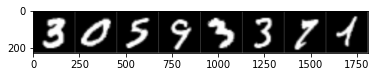

3 - three 0 - zero 5 - five 9 - nine 3 - three 3 - three 7 - seven 1 - one


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch)))

# Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
net = Net()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)
net = net.to(device)

# Training & Params

In [9]:
step = 0
loss_train = []
loss_val = []

In [10]:
net = net.train()
min_loss = 100
patience = 5
training_loss_store = []
validation_loss_store = []

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epoch_list = []
loss_list = []

In [12]:
len(trainloader)

7500

In [13]:
print('training started.............................................')
start_time = time.time()
total_epoch = 5
for epoch in range(total_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_list.append(epoch)
    train_loss = 0
    for i, data in enumerate(trainloader, 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        train_loss += loss.item() * inputs.size(0)
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            loss_train = []
            running_loss = 0.0

    train_loss = train_loss / len(trainloader)
    loss_list.append(train_loss)      
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            torch.save(net.state_dict(), 'Own_Model.pt')
            print(str(val_loss))
            
            print('performance improved with validation loss ' + str(val_loss))
            
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            
        if no_impr_epoch > patience:
            print('stop training')
            break
    
print('Finished Training................................................')
end_time = time.time()

training started.............................................
[1,  2000] loss: 0.598
[1,  4000] loss: 0.245
[1,  6000] loss: 0.204
Finished training for epoch 0 time taken = 249.6625897884369
################################evaluation###########################

tensor(0.1484, device='cuda:0')
performance improved with validation loss tensor(0.1484, device='cuda:0')
[2,  2000] loss: 0.121
[2,  4000] loss: 0.121
[2,  6000] loss: 0.108
Finished training for epoch 1 time taken = 522.1898717880249
################################evaluation###########################

tensor(0.0866, device='cuda:0')
performance improved with validation loss tensor(0.0866, device='cuda:0')
[3,  2000] loss: 0.068
[3,  4000] loss: 0.064
[3,  6000] loss: 0.067
Finished training for epoch 2 time taken = 793.8494708538055
################################evaluation###########################

tensor(0.0745, device='cuda:0')
performance improved with validation loss tensor(0.0745, device='cuda:0')
[4,  2000] loss: 

# Testing & Accuracy

In [14]:
PATH = '/content/Own_Model.pt'
own_model = Net()
own_model = own_model.to(device)
own_model.load_state_dict(torch.load(PATH))

own_model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

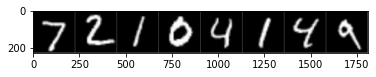

Ground Truth:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine
Predicted:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine


In [16]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch)))
outputs = own_model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch)))

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = own_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 97 %


In [18]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = own_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 98 %
Accuracy of 1 - one : 99 %
Accuracy of 2 - two : 96 %
Accuracy of 3 - three : 97 %
Accuracy of 4 - four : 97 %
Accuracy of 5 - five : 98 %
Accuracy of 6 - six : 98 %
Accuracy of 7 - seven : 96 %
Accuracy of 8 - eight : 97 %
Accuracy of 9 - nine : 96 %


# Transfer Learning

Resnet 18 model
Changing Last layer based on Number of Out Features or Classes

In [19]:
net = torchvision.models.resnet18(pretrained = True)
net.fc = nn.Linear(in_features=512, out_features=len(classes))
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
step = 0
loss_train = []
loss_val = []

In [21]:
net = net.train()
min_loss = 100
patience = 5
training_loss_store = []
validation_loss_store = []

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epoch_list = []
loss_list = []

In [23]:
print('training started.............................................')
start_time = time.time()
total_epoch = 5
for epoch in range(total_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_list.append(epoch)
    train_loss = 0
    for i, data in enumerate(trainloader, 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        train_loss += loss.item() * inputs.size(0)
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            loss_train = []
            running_loss = 0.0

    train_loss = train_loss / len(trainloader)
    loss_list.append(train_loss)      
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            torch.save(net.state_dict(), 'Res18.pt')
            print(str(val_loss))
            
            print('performance improved with validation loss ' + str(val_loss))
            
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            
        if no_impr_epoch > patience:
            print('stop training')
            break
    
print('Finished Training................................................')
end_time = time.time()

training started.............................................
[1,  2000] loss: 0.159
[1,  4000] loss: 0.058
[1,  6000] loss: 0.050
Finished training for epoch 0 time taken = 689.3873567581177
################################evaluation###########################

tensor(0.0173, device='cuda:0')
performance improved with validation loss tensor(0.0173, device='cuda:0')
[2,  2000] loss: 0.043
[2,  4000] loss: 0.027
[2,  6000] loss: 0.028
Finished training for epoch 1 time taken = 1411.9282984733582
################################evaluation###########################

no improvement with prev best model 1th
[3,  2000] loss: 0.015
[3,  4000] loss: 0.015
[3,  6000] loss: 0.017
Finished training for epoch 2 time taken = 2135.4603073596954
################################evaluation###########################

tensor(0.0166, device='cuda:0')
performance improved with validation loss tensor(0.0166, device='cuda:0')
[4,  2000] loss: 0.009
[4,  4000] loss: 0.010
[4,  6000] loss: 0.011
Finished tra

In [24]:
PATH = '/content/Res18.pt'
resnet_model = net
resnet_model = resnet_model.to(device)
resnet_model.load_state_dict(torch.load(PATH))

resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()

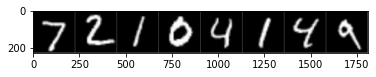

Ground Truth:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine
Predicted:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine


In [26]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch)))
outputs = resnet_model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch)))

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 99 %


In [28]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 100 %
Accuracy of 1 - one : 99 %
Accuracy of 2 - two : 99 %
Accuracy of 3 - three : 99 %
Accuracy of 4 - four : 98 %
Accuracy of 5 - five : 99 %
Accuracy of 6 - six : 98 %
Accuracy of 7 - seven : 99 %
Accuracy of 8 - eight : 99 %
Accuracy of 9 - nine : 99 %


Freezing the previous layer and training only the last layer

In [29]:
net = torchvision.models.resnet18(pretrained = True)
for params in net.parameters():
    params.requires_grad = False
net.fc = nn.Linear(in_features=512, out_features=len(classes))
net = net.to(device)

In [30]:
step = 0
loss_train = []
loss_val = []

In [31]:
net = net.train()
min_loss = 100
patience = 5
training_loss_store = []
validation_loss_store = []

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epoch_list = []
loss_list = []

In [33]:
print('training started.............................................')
start_time = time.time()
total_epoch = 5
for epoch in range(total_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_list.append(epoch)
    train_loss = 0
    for i, data in enumerate(trainloader, 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        train_loss += loss.item() * inputs.size(0)
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            loss_train = []
            running_loss = 0.0

    train_loss = train_loss / len(trainloader)
    loss_list.append(train_loss)      
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            torch.save(net.state_dict(), 'Res18_freezed.pt')
            print(str(val_loss))
            
            print('performance improved with validation loss ' + str(val_loss))
            
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            
        if no_impr_epoch > patience:
            print('stop training')
            break
    
print('Finished Training................................................')
end_time = time.time()

training started.............................................
[1,  2000] loss: 0.564
[1,  4000] loss: 0.340
[1,  6000] loss: 0.286
Finished training for epoch 0 time taken = 274.9602060317993
################################evaluation###########################

tensor(0.1393, device='cuda:0')
performance improved with validation loss tensor(0.1393, device='cuda:0')
[2,  2000] loss: 0.137
[2,  4000] loss: 0.132
[2,  6000] loss: 0.133
Finished training for epoch 1 time taken = 584.7715089321136
################################evaluation###########################

tensor(0.1225, device='cuda:0')
performance improved with validation loss tensor(0.1225, device='cuda:0')
[3,  2000] loss: 0.117
[3,  4000] loss: 0.115
[3,  6000] loss: 0.114
Finished training for epoch 2 time taken = 894.4474692344666
################################evaluation###########################

tensor(0.1107, device='cuda:0')
performance improved with validation loss tensor(0.1107, device='cuda:0')
[4,  2000] loss: 

In [34]:
PATH = '/content/Res18_freezed.pt'
resnet_model = net
resnet_model = resnet_model.to(device)
resnet_model.load_state_dict(torch.load(PATH))

resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()

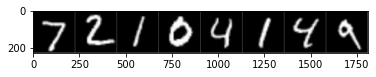

Ground Truth:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine
Predicted:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine


In [36]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch)))
outputs = resnet_model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch)))

In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 96 %


In [38]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 98 %
Accuracy of 1 - one : 99 %
Accuracy of 2 - two : 95 %
Accuracy of 3 - three : 95 %
Accuracy of 4 - four : 97 %
Accuracy of 5 - five : 95 %
Accuracy of 6 - six : 97 %
Accuracy of 7 - seven : 95 %
Accuracy of 8 - eight : 97 %
Accuracy of 9 - nine : 96 %
